# Grupo Bimbo Inventory Demand

Notebook con la implementación del modelo para [esta](https://www.kaggle.com/c/grupo-bimbo-inventory-demand) competencia en kaggle.


### Ideas principales

* Ocupar redes neuronales con la librería tensorflow.
* Ocupar procesos guassianos con librería por seleccionar.

### Archivos

* train.csv — the training set
* test.csv — the test set
* sample_submission.csv — a sample submission file in the correct format
* cliente_tabla.csv — client names (can be joined with train/test on Cliente_ID)
* producto_tabla.csv — product names (can be joined with train/test on Producto_ID)
* town_state.csv — town and state (can be joined with train/test on Agencia_ID)


### Features

* Semana — Week number (From Thursday to Wednesday)
* Agencia_ID — Sales Depot ID
* Canal_ID — Sales Channel ID
* Ruta_SAK — Route ID (Several routes = Sales Depot)
* Cliente_ID — Client ID
* NombreCliente — Client name
* Producto_ID — Product ID
* NombreProducto — Product Name
* Venta_uni_hoy — Sales unit this week (integer)
* Venta_hoy — Sales this week (unit: pesos)
* Dev_uni_proxima — Returns unit next week (integer)
* Dev_proxima — Returns next week (unit: pesos)
* Demanda_uni_equil — Adjusted Demand (integer) (This is the target you will predict)

# Análisis de los datos

Primero importamos las librerías necesarias

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import csv
import matplotlib.pyplot as plt
import time
import pandas as pd

Generamos una función para leer los datos. Retorna un dataFrame (pandas) de los datos.

In [2]:
# fileName: Name of the csv file.
# Columns: Array with the strings of each column in order.
# rows: Number of rows to be read. None = All.
def readData(fileName, columns, rows=None):
    print('Reading file:', fileName)
    start = time.time()
    ret = pd.read_csv(fileName, usecols=columns, nrows=rows)
    finish = time.time()
    print('Shape:', str(ret.shape))
    print('Execution time (seconds):', str(finish-start))
    return ret

**NOTA:** Importar una columna completa del archivo train demora aproximadamente 1 minuto.

In [3]:
# How many rows we'll load
total_loaded = 1000000

# Import the dataset
columns = ['Semana', 'Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID', 'Demanda_uni_equil']
dataset = readData('Archivos/train.csv', columns, rows=total_loaded)

Reading file: Archivos/train.csv
Shape: (1000000, 7)
Execution time (seconds): 1.308349609375


Inspeccionemos los datos primero antes de generar cualquier modelo.  
Nuestro valor objetivo es la última columna de nuestros datos: *Demanda_uni_equil*, veamos como se distribuye sobre los datos que hemos tomado.

In [14]:
# Recieves an array of elements and plot its histogram
# array: Values
# maxValue: Max value to be shown in the histogram
def toHist(array, maxValue, title='', xlabel=''):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.hist(array[array<maxValue], bins=200, color='blue')
    plt.show()

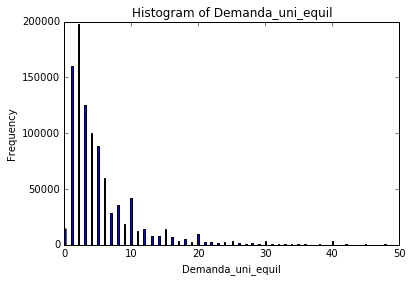

In [15]:
demanda_uni_equil = dataset['Demanda_uni_equil']
toHist(demanda_uni_equil, 50, 'Histogram of Demanda_uni_equil', 'Demanda_uni_equil')

### Histograma por semana

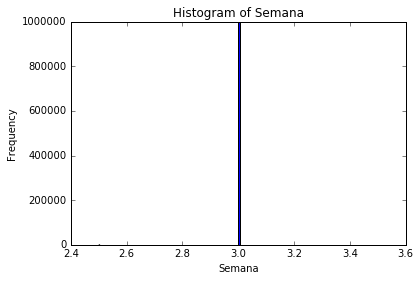

In [16]:
semana = dataset['Semana']
toHist(semana, 10, 'Histogram of Semana', 'Semana')

### Histograma por 'Agencia_ID'

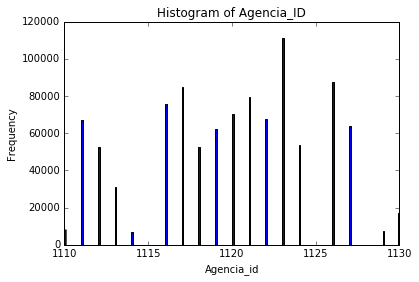

count    1000000.000000
mean        1119.880522
std            4.943890
min         1110.000000
25%         1117.000000
50%         1120.000000
75%         1123.000000
max         1130.000000
Name: Agencia_ID, dtype: float64


In [42]:
agencia_id = dataset['Agencia_ID']
toHist(agencia_id, 2000, 'Histogram of Agencia_ID', 'Agencia_id')
dscrb = agencia_id.describe()
print(dscrb)

En este caso tenemos que las id de las agencias van desde 1110 hasta 1130 (usando el primer millón de ejemplos), estos valores son muy grandes y se podrían poner entorno a cero y entre -1 y 1.

Mean: -0.0119478
Max: 1.0
Min: -1.0
Std: 0.494388784334


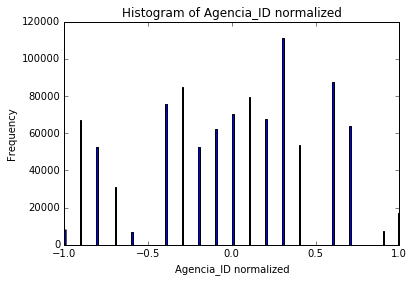

In [52]:
npagencia_id = agencia_id.as_matrix().astype('float64')
min = npagencia_id.min()
max = npagencia_id.max()
# Center in zero:
npagencia_id = (npagencia_id - min - (max-min)/2) / ((max-min)/2)
print('Mean:', npagencia_id.mean())
print('Max:', npagencia_id.max())
print('Min:', npagencia_id.min())
print('Std:', npagencia_id.std())
toHist(npagencia_id, 2, 'Histogram of Agencia_ID normalized', 'Agencia_ID normalized')

### Histograma para 'Canal_ID'

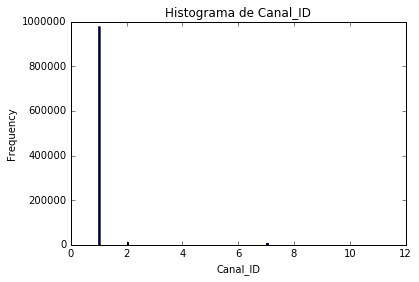

In [22]:
canal_id = dataset['Canal_ID']
toHist(canal_id, 20, 'Histograma de Canal_ID', 'Canal_ID')

### Histograma para Ruta_SAK

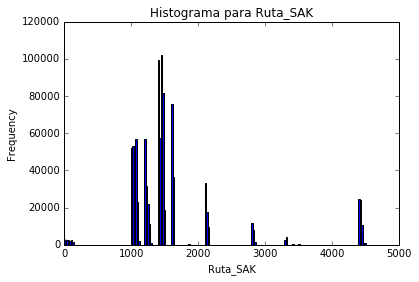

In [25]:
ruta_sak = dataset['Ruta_SAK']
toHist(ruta_sak, 5000, 'Histograma para Ruta_SAK', 'Ruta_SAK')

### Histograma Cliente_ID

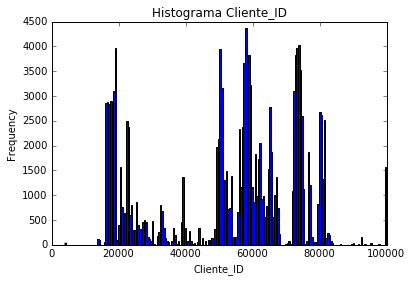

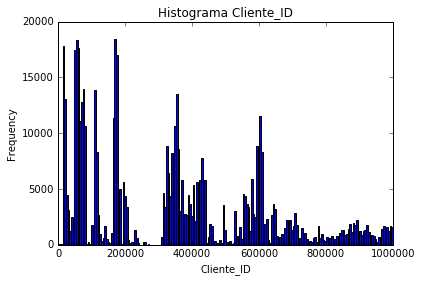

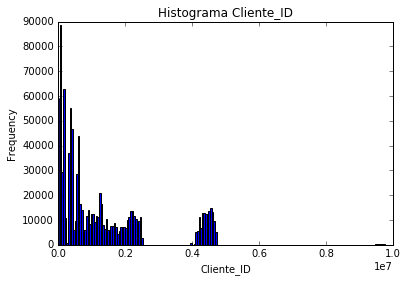

In [34]:
cliente_id = dataset['Cliente_ID']
toHist(cliente_id, 100000, 'Histograma Cliente_ID', 'Cliente_ID')
toHist(cliente_id, 1000000, 'Histograma Cliente_ID', 'Cliente_ID')
toHist(cliente_id, 10000000, 'Histograma Cliente_ID', 'Cliente_ID')

### Histograma Producto_ID

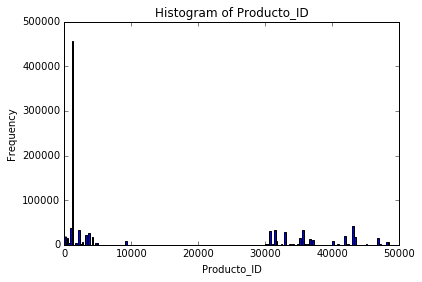

In [36]:
producto_id = dataset['Producto_ID']
toHist(producto_id, 50000, 'Histogram of Producto_ID', 'Producto_ID')

Función para poder agrupar los valores de un dataFrame de acuerdo a los valores de cierta columna. Nos retorna una tupla con todos los valores distintos de la columna y un diccionario donde la llave es el valor y retorna un dataFrame con todas las filas con ese valor en la columna específica.

In [8]:
# Recieves a dataFrame and a column name (string) and returns a tuple 
# with the keys and a dict
# where the key is de column value and the value is a dataFrame with all
# the rows that have that column value.
def groupBy(dataFrame, columnName):
    different_values = dataFrame[columnName].drop_duplicates()
    dictionary = dict()
    for value in different_values:
        # Select the data that have value in the columnName field.
        data = dataFrame.loc[dataFrame[columnName]==value]
        dictionary[value] = data
    return (different_values, dictionary)

In [10]:
(key, dct) = groupBy(dataset, 'Cliente_ID')
print(key.shape)

(58794,)


La función anterior se usaba, ya no.

# Arreglar inputs

Tenemos que normalizar las variables. Se tiene que lograr media cero y ojalá con valores pequeños (por ej: entre -1 y 1 todos los posibles casos). Buscamos también que todos los input tengan covarianza semejante, para así evitar formas de elipses y tener algo más cercano a una esfera.  
Se puede usar esta fórmula para la covarianza:
$$ C_{i} = \frac{1}{N} \Sigma_{n=1}^{N} z_{i}^{n} $$
Donde $z_{i}^{n}$ es la componente $i$-ésima del input $n$. Todo esto según [este](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) paper.  
Además nos gustaría que los input no estén correlacionados. Para nuestra ventaja, según [estos](http://blog.nycdatascience.com/student-works/predicting-demand-historical-sales-data-grupo-bimbo-kaggle-competition/) análisis, las únicas cosas que están claramente correlacionadas son venta_uni_hoy y demanda_uni_equil, que es nuestro target.

# Modelamiento con NN

A priori, haremos que la red reciba como input las 7 características que entrega el archivo test. Ocuparemos la función de error del programa.

In [7]:
# Lets define our accuracy
def accuracy(predictions, real_outputs):
    # It's the mean of our cost function across the predictions and results.
    return np.sqrt( np.mean( np.square(np.log(predictions+1) - np.log(real_outputs+1)) ))

In [8]:
# The data is divided (seudo)randomnly in 3 groups: train_dataset, valid_dataset, and test_dataset.

train_size = 30000
valid_size = 10000
test_size = 10000

#-------------------------------------------------------
# TODO: Normalizar variables. Se tiene que lograr media cero y ojalá con valores pequeños (por ej: entre -1 y 1
#       todos los posibles casos). Buscamos también que todos los input tengan covarianza semejante, para así
#       evitar formas de elipses y tener algo más cercano a una esfera.
#-------------------------------------------------------

# 6 feautres + output
train = dataset.sample(train_size)
valid = dataset.sample(valid_size)
test = dataset.sample(test_size)

# 6 features only, now they are numpy arrays
train_dataset = train.drop('Demanda_uni_equil', axis=1).as_matrix().astype('float32')
valid_dataset = valid.drop('Demanda_uni_equil', axis=1).as_matrix().astype('float32')
test_dataset = test.drop('Demanda_uni_equil', axis=1).as_matrix().astype('float32')

# Outputs
train_output = train['Demanda_uni_equil'].as_matrix().astype('float32').reshape((train_size, 1))
valid_output = valid['Demanda_uni_equil'].as_matrix().astype('float32').reshape((valid_size, 1))
test_output = test['Demanda_uni_equil'].as_matrix().astype('float32').reshape((test_size, 1))

print('Train dataset', train_dataset.shape)
print('      outputs', train_output.shape)
print('Valid dataset', valid_dataset.shape)
print('      outputs', valid_output.shape)
print('Test  dataset', test_dataset.shape)
print('      outputs', test_output.shape)

Train dataset (30000, 6)
      outputs (30000, 1)
Valid dataset (10000, 6)
      outputs (10000, 1)
Test  dataset (10000, 6)
      outputs (10000, 1)


# Nota
Los modelos no estan funcionando bien, devuelven puros nan. Al parecer es la función de costo. La cambié y funcionó (devolvió números).  
IDEAS:
* Mala elección de la función loss.
* Los input son demasiado grandes, hay overflow. Esto porque a veces muestra cuanto es el valor del loss y son número gigantescos. SOL: Encodear las variables muy grandes.

In [51]:
# The logistic model

# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

features = 6

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # Load the training, validation and test data into constants that are
    # attached to the graph.
    tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
    tf_train_output = tf.constant(train_output[:train_subset])
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    # These are the parameters that we are going to be training. The weight
    # matrix will be initialized using random valued following a (truncated)
    # normal distribution. The biases get initialized to zero.
    weights = tf.Variable(
      tf.truncated_normal([features, 1]))
    biases = tf.Variable(tf.zeros([1]))
  
    # Training computation.
    
    output = tf.matmul(tf_train_dataset, weights) + biases
    loss = tf.nn.l2_loss( output - tf_train_output)
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, tf_train_output))
    #loss = tf.sqrt( tf.reduce_mean( tf.square(tf.log(output+1) - tf.log(tf_train_output+1)) ))
    #loss = tf.reduce_mean( tf.log(output+1) - tf.log(tf_train_output+1) )

    # Optimizer.
    # We are going to find the minimum of this loss using gradient descent.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    # These are not part of training, but merely here so that we can report
    # accuracy figures as we train.
    train_prediction = output
    valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
    test_prediction = tf.matmul(tf_test_dataset, weights) + biases

In [52]:
# Let's run it:

num_steps = 801

with tf.Session(graph=graph) as session:
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the
    # biases. 
    tf.initialize_all_variables().run()
    print('Initialized')
    
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, l, predictions = session.run([optimizer, loss, train_prediction])
        
        if (step % 100 == 0):
            print('------------------')
            print('Loss at step %d: %f' % (step, l))
            print('Training loss:', accuracy(predictions, train_output[:train_subset, :]))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation loss:', accuracy(
                valid_prediction.eval(), valid_output))
    print('Test loss:', accuracy(test_prediction.eval(), test_output))

Initialized
------------------
Loss at step 0: 1917697797390336.000000
Training loss: 10.7914
Validation loss: nan
------------------
Loss at step 100: nan
Training loss: nan
Validation loss: nan
------------------
Loss at step 200: nan
Training loss: nan
Validation loss: nan
------------------
Loss at step 300: nan
Training loss: nan
Validation loss: nan
------------------
Loss at step 400: nan
Training loss: nan
Validation loss: nan
------------------
Loss at step 500: nan
Training loss: nan
Validation loss: nan
------------------
Loss at step 600: nan
Training loss: nan
Validation loss: nan
------------------
Loss at step 700: nan
Training loss: nan
Validation loss: nan
------------------
Loss at step 800: nan
Training loss: nan
Validation loss: nan
Test loss: nan


# Modelo que no logro correr sin nans

In [25]:
# Model deep neural network with stochastic gradient descent for speed.

# How many features we want to use
features = 6
# Size of the placeholder in the train input data.
batch_size = 512
hidden_nodes = 1024
beta = 0.001

graph = tf.Graph()

with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, features))
    # We only have one output, the prediction.
    tf_train_outputs = tf.placeholder(tf.float32, shape=(batch_size, 1))
    # The valid dataset and the test dataset remain as constants.
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    #------------
    # Variables:
    #------------
    
    # First layer
    weights1 = tf.Variable(
        tf.truncated_normal([features, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    
    # Hidden layer
    weights2 = tf.Variable(
        tf.truncated_normal([hidden_nodes, 1]))
    biases2 = tf.Variable(tf.zeros([1]))
    
    #----------------------
    # Training computation.
    #----------------------
    
    # Outputs after the first layer:
    # We are using RELU, thats the non linearity in our model
    outputs1 = tf.nn.relu( tf.matmul(tf_train_dataset, weights1) + biases1 )
    
    # Output after the second layer:
    output = tf.matmul(outputs1, weights2) + biases2
    
    #-------
    # Loss
    #-------
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output, tf_train_outputs))
    #loss = tf.sqrt( tf.reduce_mean( tf.square(tf.log(output+1) - tf.log(tf_train_outputs+1)) )) #+beta*tf.l2_loss(weights1) + tf.nn.l2_loss(weights2)
    
    #-----------
    # Optimizer
    #-----------
  
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_prediction = output
    valid_prediction = tf.matmul(
        tf.nn.relu( tf.matmul(tf_valid_dataset, weights1) + biases1 ) , weights2) + biases2
    test_prediction = tf.matmul(
        tf.nn.relu( tf.matmul(tf_test_dataset, weights1) + biases1 ) , weights2) + biases2

In [26]:
# Run the model

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_output.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_outputs = train_output[offset:(offset + batch_size),:]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_outputs : batch_outputs}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print('Minibatch accuracy:', accuracy(predictions, batch_outputs))
            print('Validation accuracy:', accuracy(
                valid_prediction.eval(), valid_output))
    print('Test accuracy:', accuracy(test_prediction.eval(), test_output))

Initialized
Minibatch loss at step 0: 0.000000
Minibatch accuracy: nan
Validation accuracy: 46.8299
Minibatch loss at step 100: nan
Minibatch accuracy: nan
Validation accuracy: nan
Minibatch loss at step 200: nan
Minibatch accuracy: nan
Validation accuracy: nan
Minibatch loss at step 300: nan
Minibatch accuracy: nan
Validation accuracy: nan
Minibatch loss at step 400: nan
Minibatch accuracy: nan
Validation accuracy: nan
Minibatch loss at step 500: nan
Minibatch accuracy: nan
Validation accuracy: nan
Minibatch loss at step 600: nan
Minibatch accuracy: nan
Validation accuracy: nan
Minibatch loss at step 700: nan
Minibatch accuracy: nan
Validation accuracy: nan
Minibatch loss at step 800: nan
Minibatch accuracy: nan
Validation accuracy: nan


KeyboardInterrupt: 